In [56]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import CubicSpline
from scipy.interpolate import RegularGridInterpolator

In [59]:
class IsingModel:
    def __init__(self, L, T):
        #parametros do modelo
        self.L = L
        self.T = T

        #array com os spins
        self.spins = np.ones((L,L))

        #arrays para guardar evoluções das variáveis
        self.energies= [self.calc_ener_total()]
        self.magnetizations= [L**2]

        #energia e magnetização total
        self.energy_total = self.calc_ener_total()
        self.magnet_total = np.sum(self.spins)

    def calc_ener_spin(self, i, j):
        #calcular a energia de um spin
        spin= self.spins[i,j]
        neighbours= (
        self.spins[(i+1)%self.L, j] + 
        self.spins[i, (j+1)%self.L] + 
        self.spins[(i-1)%self.L, j] + 
        self.spins[i, (j-1)%self.L]
        )
        energy=-spin*neighbours
        return energy
    
    def calc_ener_total( self ):
        energy=0
        for i in range(self.L):
            for j in range(self.L):
                energy+= -self.spins[i,j]*(self.spins[(i+1)%self.L,j]+ self.spins[i,(j+1)%self.L])
        return energy
    
    def calc_ener ( self ):
        energy=self.energy_total/self.L**2
        return energy
    
    def calc_mag( self ):
        mag = self.magnet_total
        return mag
    

    def iter_monte_carlo(self,n_iter):

        #calcular a energia do sistema inicialmente
        E = self.energies[0]
        Mag = self.magnetizations[0]

        #iterar com o método de Metropolis Hastings
        for _ in tqdm(range(n_iter), desc=f"L={self.L:6d},T={self.T:8f}"):
            #proposta: spin flip
            i = np.random.randint(0, self.L)
            j = np.random.randint(0, self.L)
            prop = self.spins.copy()
            prop[i, j] *= -1

            #calcular a probabilidade de a proposta ser aceite
            Delta_E = -2*self.calc_ener_spin(i, j)
            Delta_Mag = -2*self.spins[i,j]
            R = np.exp(-Delta_E/(self.T))
            
            u = np.random.uniform(0, 1)
            if R > u:
                self.spins = prop
                E += Delta_E
                Mag += Delta_Mag
                self.energy_total = E
                self.magnet_total = Mag

            self.energies.append(E)
            self.magnetizations.append(Mag)
    
    @property
    def energy(self):
        return np.array(self.energies)
    


## 1. Tempo de Termalização

**a)** Para cada combinação de L e T, corremos a simulação iter_monte_carlo, obtendo uma lista de como variou a energia a cada passo da iteração (ising.energies). A n-ésima entrada dessa lista (ising.energies[n-1]) dá a energia total do sistema após n iterações, pelo que a energia média, e, em função de n é ising.energies[n-1]/L^2.

L=   128,T=4.000000: 100%|██████████| 10000/10000 [00:00<00:00, 87454.03it/s]


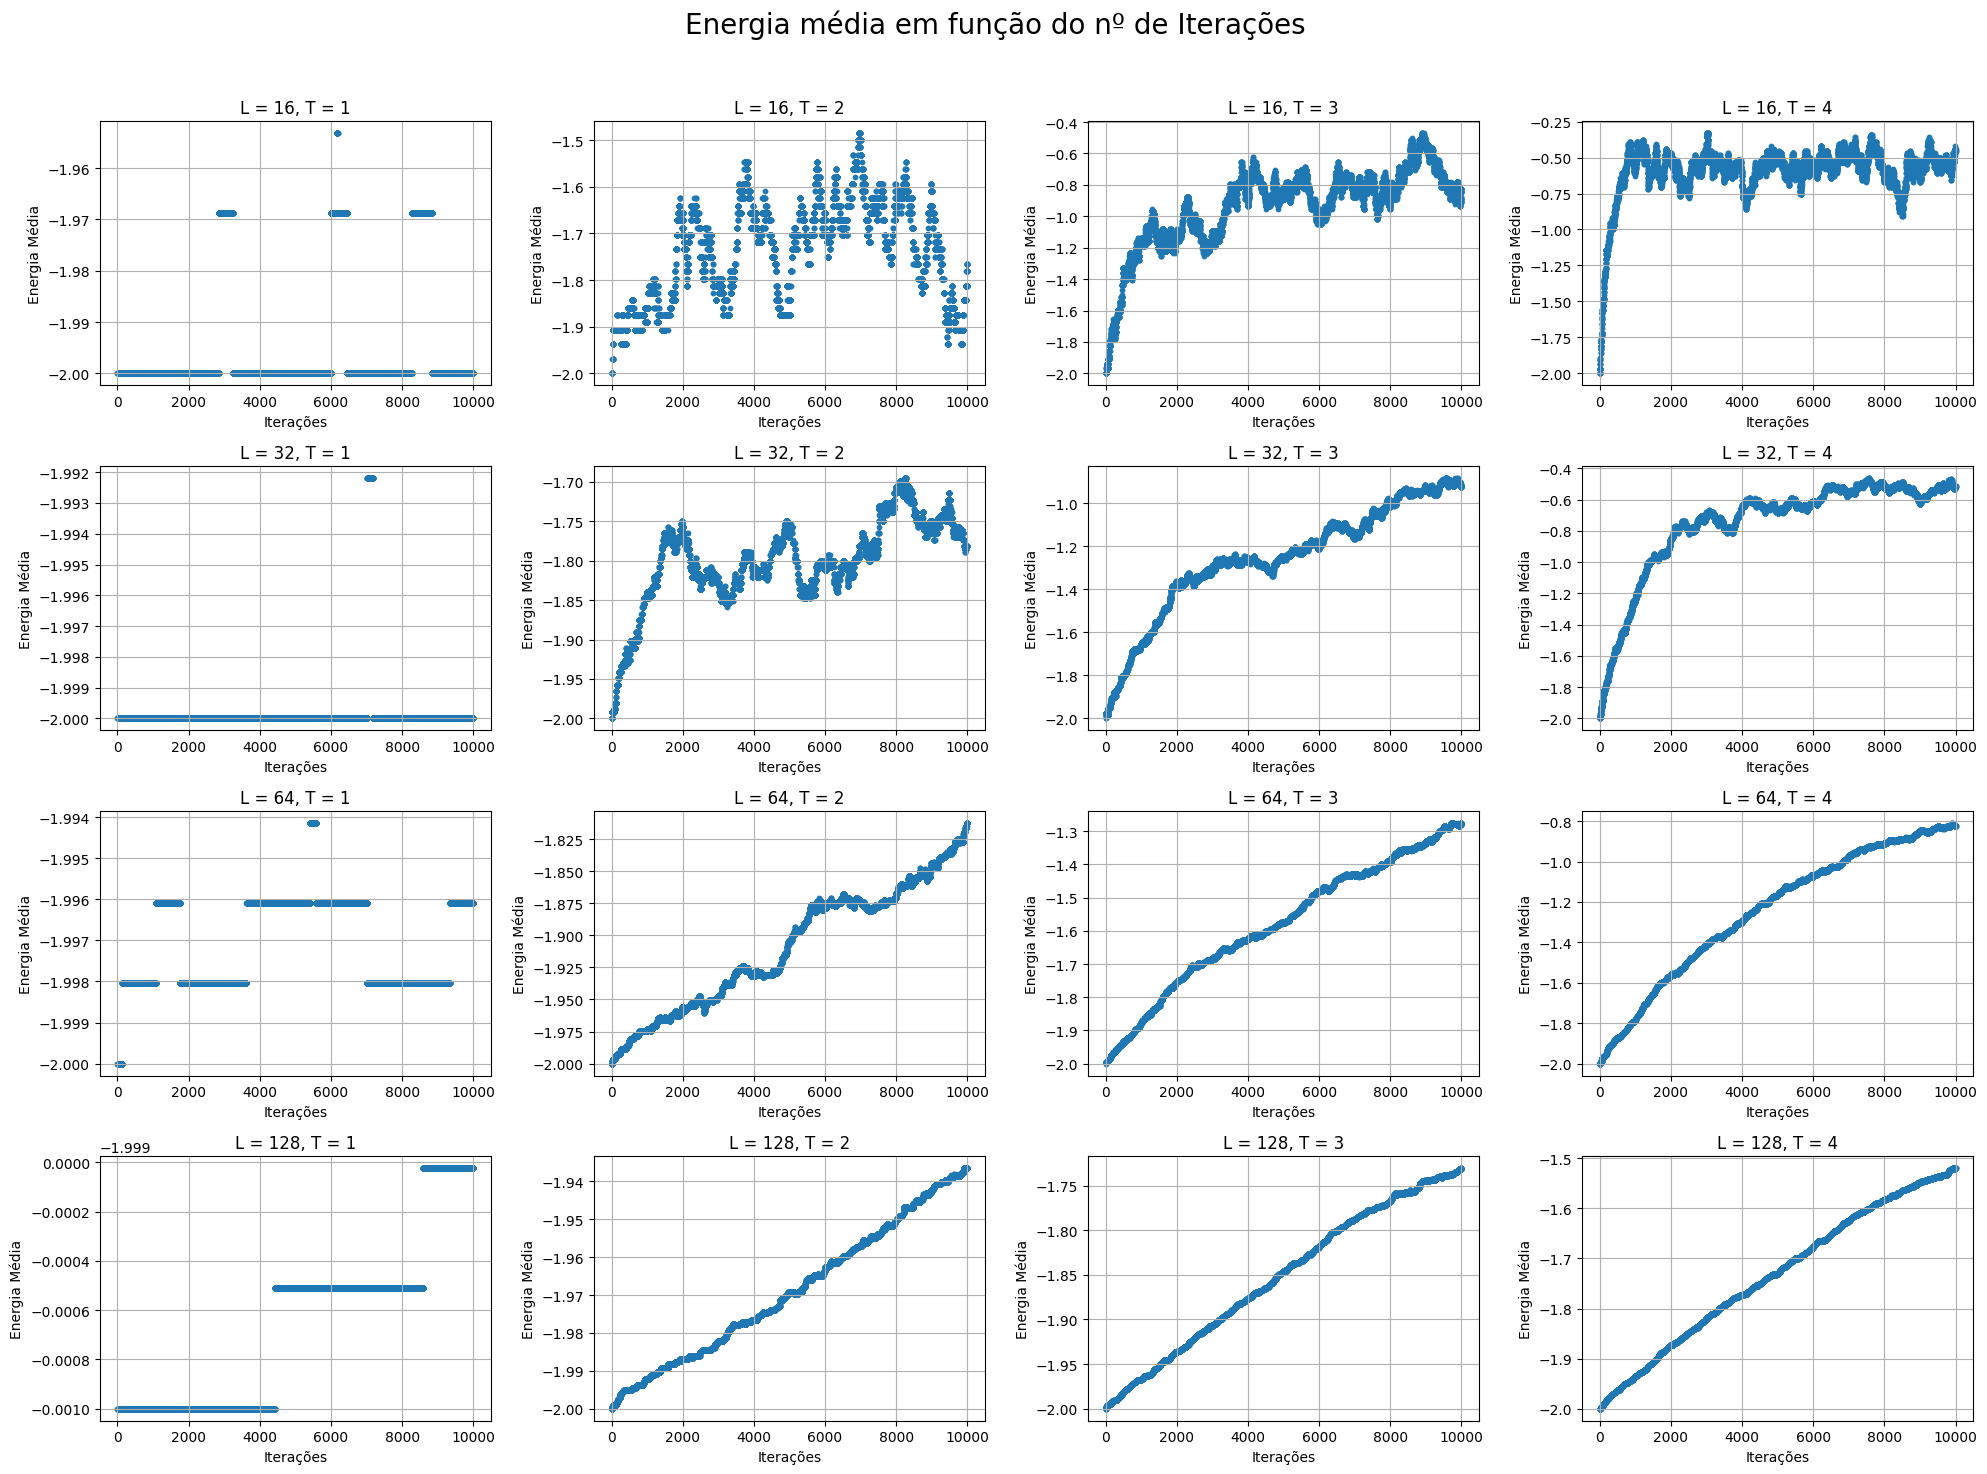

In [60]:
L_array = [16, 32, 64, 128]
T_array = [1, 2, 3, 4]
N = 10000 #limite superior para o número de iterações

fig, axes = plt.subplots(len(L_array), len(T_array), figsize=(20, 15))
fig.suptitle('Energia média em função do nº de Iterações', fontsize=20)

for i, L in enumerate(L_array):
    for j, T in enumerate(T_array):
        
        ising = IsingModel(L, T)
        ising.iter_monte_carlo(N)
        avg_ener = np.array(ising.energies[1:])/(L*L)

        ax = axes[i, j]
        ax.scatter(np.arange(1, N + 1), avg_ener, s=10)
        ax.set_title(f'L = {L}, T = {T}')
        ax.set_xlabel('Iterações')
        ax.set_ylabel('Energia Média')
        ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajusta o layout para dar espaço ao título
plt.show()

**b)** Fit

In [ ]:
def ener_func(N, ef, tau):
    return ef + (e0 - ef) * np.exp(-N / tau)

def guesses_for_ef_and_tau(energy_vals):
    #o guess para ef será a média dos últimos 10% de valores
    ef_guess = np.mean(avg_ener[-int(0.1 * len(avg_ener)):])
    #o guess para 

# Dicionário para guardar os parâmetros de ajuste
fit_results = {}

for i, L in enumerate(L_array):
    for j, T in enumerate(T_array):
        
        ising = IsingModel(L, T)
        ising.iter_monte_carlo(N)
        N_values = np.arange(0, N + 1)
        avg_ener = np.array(ising.energies) / (L * L)
        e0 = avg_ener[0]

        # Chamada do ajuste com estimativas iniciais
        parameters, _ = curve_fit(ener_func, N_values, avg_ener, p0=[sum(avg_ener[-50:])/50, 200])
        ef, tau = parameters

        # A chave (L,T) estará associada a um dicionário onde se guardam os valores ef e tau
        fit_results[(L, T)] = {'ef': ef, 'tau': tau}

print(fit_results)

L=   128,T=4.000000: 100%|██████████| 10000/10000 [00:00<00:00, 89690.87it/s]

{(16, 1): {'ef': np.float64(-1.9996873351149311), 'tau': np.float64(2164.5123011638416)}, (16, 2): {'ef': np.float64(-1.7815306401571909), 'tau': np.float64(366.3201228865959)}, (16, 3): {'ef': np.float64(-0.9167317582579328), 'tau': np.float64(752.9770661020558)}, (16, 4): {'ef': np.float64(-0.537895035899082), 'tau': np.float64(281.2145568643857)}, (32, 1): {'ef': np.float64(-1.994888957149355), 'tau': np.float64(835.4326569434639)}, (32, 2): {'ef': np.float64(-1.6776278634793), 'tau': np.float64(3279.811826162875)}, (32, 3): {'ef': np.float64(-0.9447251244764179), 'tau': np.float64(2496.0501558077253)}, (32, 4): {'ef': np.float64(-0.5166654835064336), 'tau': np.float64(1518.4835399180918)}, (64, 1): {'ef': np.float64(-1.999015206462784), 'tau': np.float64(129.82770527676288)}, (64, 2): {'ef': np.float64(-1.84703328112142), 'tau': np.float64(2865.027389614009)}, (64, 3): {'ef': np.float64(-1.1373385831612015), 'tau': np.float64(6306.423316864475)}, (64, 4): {'ef': np.float64(-0.56141

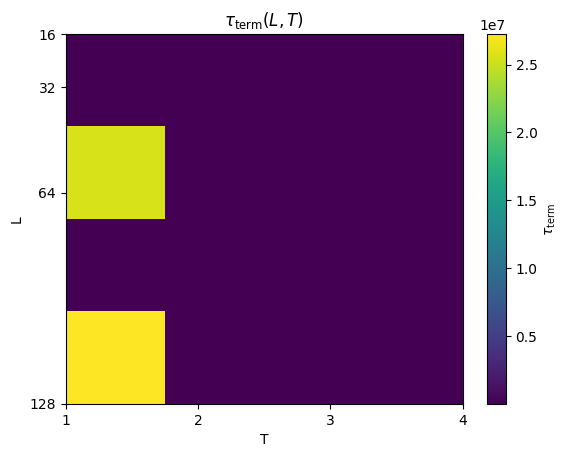

In [74]:
# Organizamos os valores de tau obtidos numa matriz (array de arrays)
L_vals = np.array(L_array)
T_vals = np.array(T_array)
tau_matrix = np.array([[fit_results[(L, T)]['tau'] for T in T_vals] for L in L_vals])

# Plot do obtido
plt.imshow(tau_matrix, extent=[T_vals[0], T_vals[-1], L_vals[-1], L_vals[0]], aspect='auto', cmap='viridis')
plt.colorbar(label=r'$\tau_{\mathrm{term}}$')
plt.xticks(T_vals)
plt.yticks(L_vals)
plt.xlabel('T')
plt.ylabel('L')
plt.title(r'$\tau_{\mathrm{term}}(L, T)$')
plt.show()

# Create interpolator
tau_interp = RegularGridInterpolator((L_vals, T_vals), tau_matrix)

## 2. Determinação da Temperatura Crítica

In [ ]:
L = 16
T = np.arange(1, 4.2, 0.2)

for t in T:
    critical_ising = IsingModel(L, t)
    critical_ising.iter_monte_carlo(1_000_000)
    quant = avg_ener

## 3. Determinação da Energia Livre de Helmholtz, F